# Learning to identify important repositories using graphical analyses on historical data

In the [graph analysis notebook](./graph_analysis.ipynb), we explored relationships between open source projects and communities by studying graphs. We explored relations such as common contributors and project activities between different GitHub repositories.

In this notebook, our aim is to leverage the graph representation techniques we explore in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find important emerging projects.

In order to do that, we test these algorithms on historical data of well known project communities. 

## Connect to Augur database

In [1]:
import psycopg2
import pandas as pd
import collections
import datetime
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories for OpenShift and Kubernetes

We start with known project communities during the years [2011-2014](https://developer.ibm.com/blogs/a-brief-history-of-red-hat-openshift/)  and color the project nodes differently as we plot the graphs. We categorize repositories into 3 buckets. 

1. **Well-known**: We categorize Kubernetes repos in this bucket. We assume that we are aware of the kubernetes community and we wish to reveal related emerging communities which are related to Kubernetes

2. **Emerging**: We categorize OpenShift repos in this bucket. We go forward with the assumption that there is an overlap of contributors between OpenShift and Kubernetes and using graph algorithms and by starting with Kubernetes repos, we will be able to discover the OpenShift community.

3. **Other communities**: In this bucket, we add other repositories belonging to most likely un-related project communities which either already are important communities or are also emerging in that time frame. We found some popular communities which emerged in the 2011-2014 time range and some already popular repositories such as Apache Hadoop, Apache Mesos, Node, Eclipse jetty.project

In [3]:
# Bucketing repositories based on a category

repos_openshift = ['https://github.com/openshift/origin',
                  'https://github.com/openshift/source-to-image',
                  'https://github.com/openshift/openshift-ansible',
                  'https://github.com/openshift/osin',
                  'https://github.com/openshift/installer']

repos_kubernetes = ['https://github.com/kubernetes/kubernetes',
                   'https://github.com/kubernetes/minikube',
                   'https://github.com/kubernetes/kops',
                   'https://github.com/kubernetes/ingress-nginx',
                   'https://github.com/kubernetes/dashboard']

# List of existing and emerging communities which emerged in 2011-2014
# https://opensource.com/life/13/12/top-open-source-projects-2013
# https://opensource.com/business/14/12/top-10-open-source-projects-2014
repos_other = ['https://github.com/apache/hadoop',
              'https://github.com/apache/mesos',
              'https://github.com/nodejs/node',
              'https://github.com/eclipse/jetty.project'] 

In [4]:
def get_repos(repos):
    
    repo_set = []
    repo_name_set = []
    for repo_git in repos:
        repo_query = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                     SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = \'{repo_git}\'
            """)

        t = engine.execute(repo_query)
        results = t.mappings().all()[0]
        repo_id = results['repo_id']
        repo_name = results['repo_name']
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)
    return repo_set, repo_name_set

In [5]:
repo_set_openshift, repo_name_set_openshift = get_repos(repos_openshift)
print(repo_set_openshift, repo_name_set_openshift)

[32413, 32390, 32537, 32408, 32010] ['origin', 'source-to-image', 'openshift-ansible', 'osin', 'installer']


In [6]:
repo_set_kubernetes, repo_name_set_kubernetes = get_repos(repos_kubernetes)
print(repo_set_kubernetes, repo_name_set_kubernetes)

[27835, 27850, 27833, 27805, 27825] ['kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard']


In [7]:
repo_set_other, repo_name_set_other = get_repos(repos_other)
print(repo_set_other, repo_name_set_other)

[28864, 29161, 33931, 25969] ['hadoop', 'mesos', 'node', 'jetty.project']


In [8]:
repo_set = repo_set_kubernetes + repo_set_openshift + repo_set_other
repo_name_set = repo_name_set_kubernetes + repo_name_set_openshift + repo_name_set_other

In [9]:
print(repo_set, repo_name_set)

[27835, 27850, 27833, 27805, 27825, 32413, 32390, 32537, 32408, 32010, 28864, 29161, 33931, 25969] ['kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard', 'origin', 'source-to-image', 'openshift-ansible', 'osin', 'installer', 'hadoop', 'mesos', 'node', 'jetty.project']


### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [10]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                i.cntrb_id,
                i.issue_id,
                i.created_at
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'issue_id', 'created_at']
issue_contrib['cntrb_id'] = issue_contrib['cntrb_id'].astype('Int64')
display(issue_contrib)
issue_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349183,2015-04-08 23:29:49
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349184,2015-04-08 23:21:29
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349185,2015-04-08 22:58:48
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349186,2015-04-08 22:46:37
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349187,2015-04-08 22:28:38
...,...,...,...,...,...,...
154441,25969,https://github.com/eclipse/jetty.project,jetty.project,<NA>,1255205,2021-12-01 21:26:00
154442,25969,https://github.com/eclipse/jetty.project,jetty.project,<NA>,1256449,2021-01-27 09:17:24
154443,25969,https://github.com/eclipse/jetty.project,jetty.project,<NA>,1260271,2017-12-20 10:24:27
154444,25969,https://github.com/eclipse/jetty.project,jetty.project,<NA>,1259448,2018-09-10 13:15:54


repo_id                int64
repo_git              object
repo_name             object
cntrb_id               Int64
issue_id               int64
created_at    datetime64[ns]
dtype: object

In [11]:
issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date

In [12]:
date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
issue_contrib = issue_contrib.loc[date_range]

In [13]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at,created_at_dt
5452,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355520,2014-06-27 07:00:52,2014-06-27
5453,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355521,2014-06-27 03:26:47,2014-06-27
5454,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355522,2014-06-27 02:22:40,2014-06-27
5455,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355516,2014-06-27 21:26:35,2014-06-27
5456,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355517,2014-06-27 21:10:14,2014-06-27


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [14]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prm.cntrb_id,
                prm.pull_request_id,
                pr.pr_created_at
                FROM
                repo r, pull_request_meta prm, pull_requests pr
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id AND
                prm.pull_request_id = pr.pull_request_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id', 'pr_created_at']
pr_contrib['cntrb_id'] = pr_contrib['cntrb_id'].astype('Int64')
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,2204694,173904,2019-08-14 17:09:20
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206573,173904,2019-08-14 17:09:20
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206229,173907,2019-08-14 18:36:38
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206573,173907,2019-08-14 18:36:38
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,2216925,173908,2019-08-14 18:50:42
...,...,...,...,...,...,...
218435,25969,https://github.com/eclipse/jetty.project,jetty.project,2206372,1024262,2015-05-13 21:10:30
218436,25969,https://github.com/eclipse/jetty.project,jetty.project,2204218,1024262,2015-05-13 21:10:30
218437,25969,https://github.com/eclipse/jetty.project,jetty.project,2204218,1024259,2015-04-20 19:44:02
218438,25969,https://github.com/eclipse/jetty.project,jetty.project,2230836,1024258,2015-04-14 01:40:08


repo_id                     int64
repo_git                   object
repo_name                  object
cntrb_id                    Int64
pull_request_id             int64
pr_created_at      datetime64[ns]
dtype: object

In [15]:
pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date

In [16]:
date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
pr_contrib = pr_contrib.loc[date_range]

In [17]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt
138432,32390,https://github.com/openshift/source-to-image,source-to-image,2212145,366896,2014-01-28 20:56:18,2014-01-28
138433,32390,https://github.com/openshift/source-to-image,source-to-image,2204295,366896,2014-01-28 20:56:18,2014-01-28
138434,32390,https://github.com/openshift/source-to-image,source-to-image,2216894,366898,2014-01-29 16:16:04,2014-01-29
138435,32390,https://github.com/openshift/source-to-image,source-to-image,2212145,366897,2014-01-29 16:10:26,2014-01-29
138436,32390,https://github.com/openshift/source-to-image,source-to-image,2204295,366897,2014-01-29 16:10:26,2014-01-29


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [18]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                ca.cntrb_id,
                c.cmt_id,
                c.cmt_date_attempted
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'cmt_id', 'cmt_date_attempted']
commit_contrib['cntrb_id'] = commit_contrib['cntrb_id'].astype('Int64')
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,2205542,88537913,2017-08-07
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,2272203,87499930,2015-07-13
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558362,2014-06-12
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558364,2014-06-12
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558366,2014-06-12
...,...,...,...,...,...,...
2027589,25969,https://github.com/eclipse/jetty.project,jetty.project,2223981,193269929,2022-02-22
2027590,25969,https://github.com/eclipse/jetty.project,jetty.project,2223981,193269933,2022-02-22
2027591,25969,https://github.com/eclipse/jetty.project,jetty.project,2262360,193270252,2022-03-02
2027592,25969,https://github.com/eclipse/jetty.project,jetty.project,2262360,193270253,2022-03-02


repo_id                        int64
repo_git                      object
repo_name                     object
cntrb_id                       Int64
cmt_id                         int64
cmt_date_attempted    datetime64[ns]
dtype: object

In [19]:
commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date

In [20]:
date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
commit_contrib = commit_contrib.loc[date_range]

In [21]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558362,2014-06-12,2014-06-12
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558364,2014-06-12,2014-06-12
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558366,2014-06-12,2014-06-12
515,27835,https://github.com/kubernetes/kubernetes,kubernetes,39204,88566373,2014-06-24,2014-06-24
516,27835,https://github.com/kubernetes/kubernetes,kubernetes,39204,88844282,2014-06-28,2014-06-28


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [22]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit

cntrb_id,27840,28077,29906,33047,39204,57925,63341,67879,91233,127646,...,2288850,2288859,2288875,2288877,2288883,2288888,2390787,2506096,2543422,2543822
repo_name,,,,,,,,,,,,,,,,,,,,,
installer,0,6,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jetty.project,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,2
kubernetes,0,0,1,1,71,0,0,3,3,0,...,1,1,1,1,1,2,9,555,0,0
node,15472,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
osin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
source-to-image,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [23]:
df_commit = df_commit.reset_index()

In [24]:
df_commit.head()

cntrb_id,repo_name,27840,28077,29906,33047,39204,57925,63341,67879,91233,...,2288850,2288859,2288875,2288877,2288883,2288888,2390787,2506096,2543422,2543822
0,installer,0,6,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,jetty.project,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,2
2,kubernetes,0,0,1,1,71,0,0,3,3,...,1,1,1,1,1,2,9,555,0,0
3,node,15472,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,osin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [26]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
3,node,27840,15472
6,installer,28077,6
14,kubernetes,29906,1
20,kubernetes,33047,1
26,kubernetes,39204,71


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [27]:
def created_melted_dfs(df):

    df = df.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
    df = df.reset_index()

    df_melted = df.melt(['repo_name'], var_name = 'cntrb_id',value_name='number')
    df_melted = df_melted[df_melted[df_melted.columns[2]] != 0]
    
    return df_melted

In [28]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_pr_contrib.head()

,repo_name,cntrb_id,number
0,jetty.project,93061,2
7,source-to-image,127041,5
10,osin,144547,1
15,source-to-image,172472,2
19,source-to-image,181894,3


In [29]:
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_issue_contrib.head()

,repo_name,cntrb_id,number
1,source-to-image,57925,2
3,source-to-image,127041,2
5,source-to-image,181894,1
7,source-to-image,2204263,1
9,source-to-image,2204329,10


### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [30]:
commit_issue = pd.merge(df_melted_commit, df_melted_issue_contrib, how="outer", on=["repo_name", "cntrb_id"])

In [31]:
merged_df = pd.merge(df_melted_pr_contrib, commit_issue, how="outer", on=["repo_name", "cntrb_id"])

In [32]:
col_list= ['number', 'number_x', 'number_y']
merged_df['total_contributions'] = merged_df[col_list].sum(axis=1)
merged_df.drop(col_list, axis=1, inplace=True)

In [33]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,jetty.project,93061.0,2.0
1,source-to-image,127041.0,7.0
2,osin,144547.0,1.0
3,source-to-image,172472.0,2.0
4,source-to-image,181894.0,15.0


### Plot Graphs

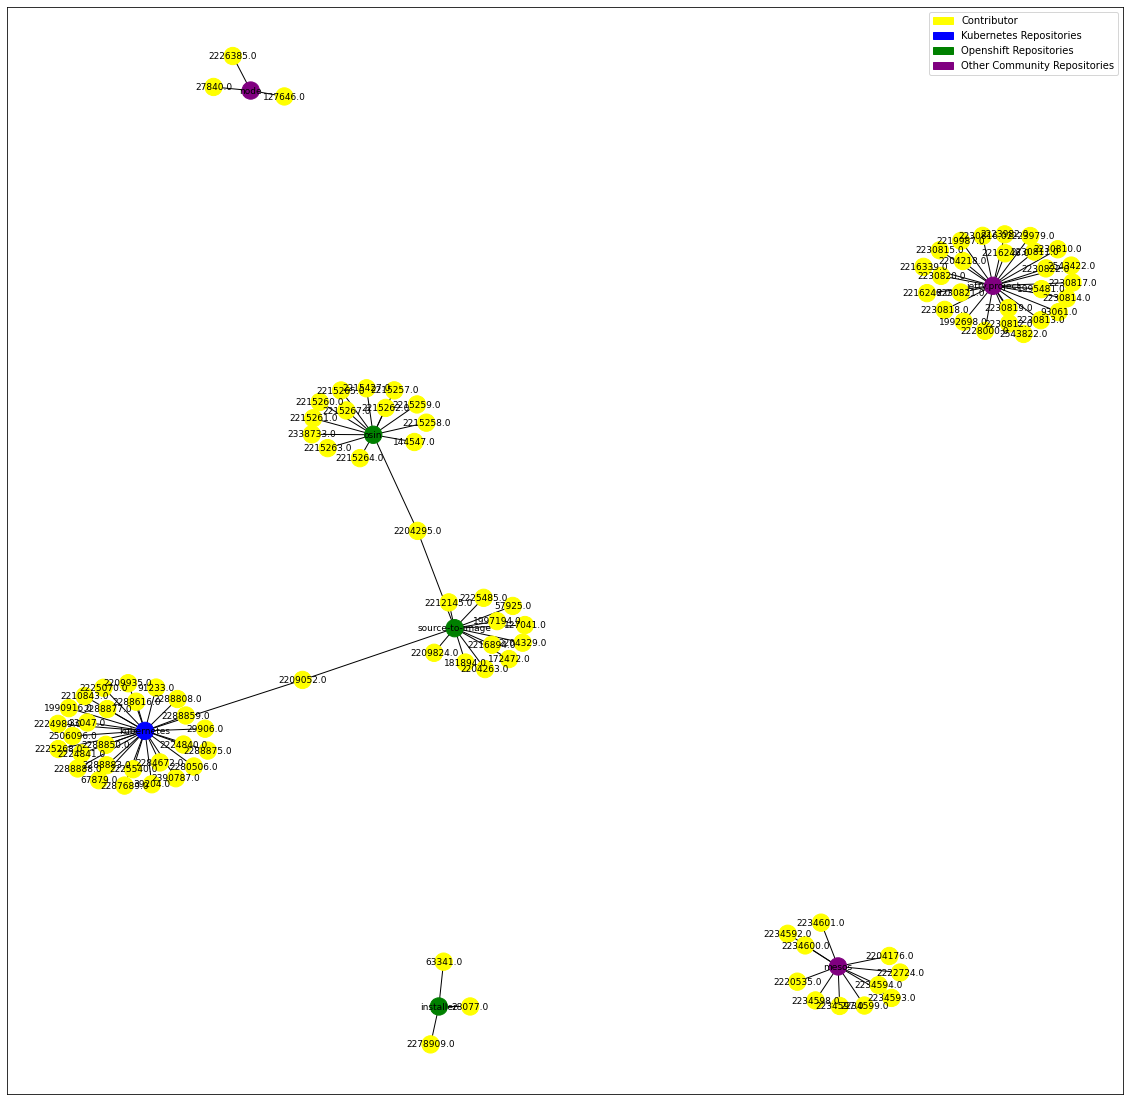

In [34]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

Repo_name = merged_df['repo_name'].to_list()
contributor_id = merged_df['cntrb_id'].to_list()

nodes = G.nodes()

colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    elif n in repo_name_set_other:
        colors.append('purple')
    else:
        colors.append('yellow')

fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repositories')
green_patch = mpatches.Patch(color='green', label='Openshift Repositories')
purple_patch = mpatches.Patch(color='purple', label='Other Community Repositories')

ax.legend(handles=[yellow_patch, blue_patch, green_patch, purple_patch])
nx.draw_networkx(G, node_color=colors, font_size=9, ax=ax)

Here we see that some of the kubernetes and openshift repositories seem to form a cluster. Some of other repositories like the jettyproject also seem to have a lot of contributors but they seem to have no links with kubernetes repositories. Lets analyze this further

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. In order to run the PageRank algorithm we will need to convert the undirected graph to a directed graph by adding two edges for each edge. The PageRank algorithm will help us identify the "top repositories".

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

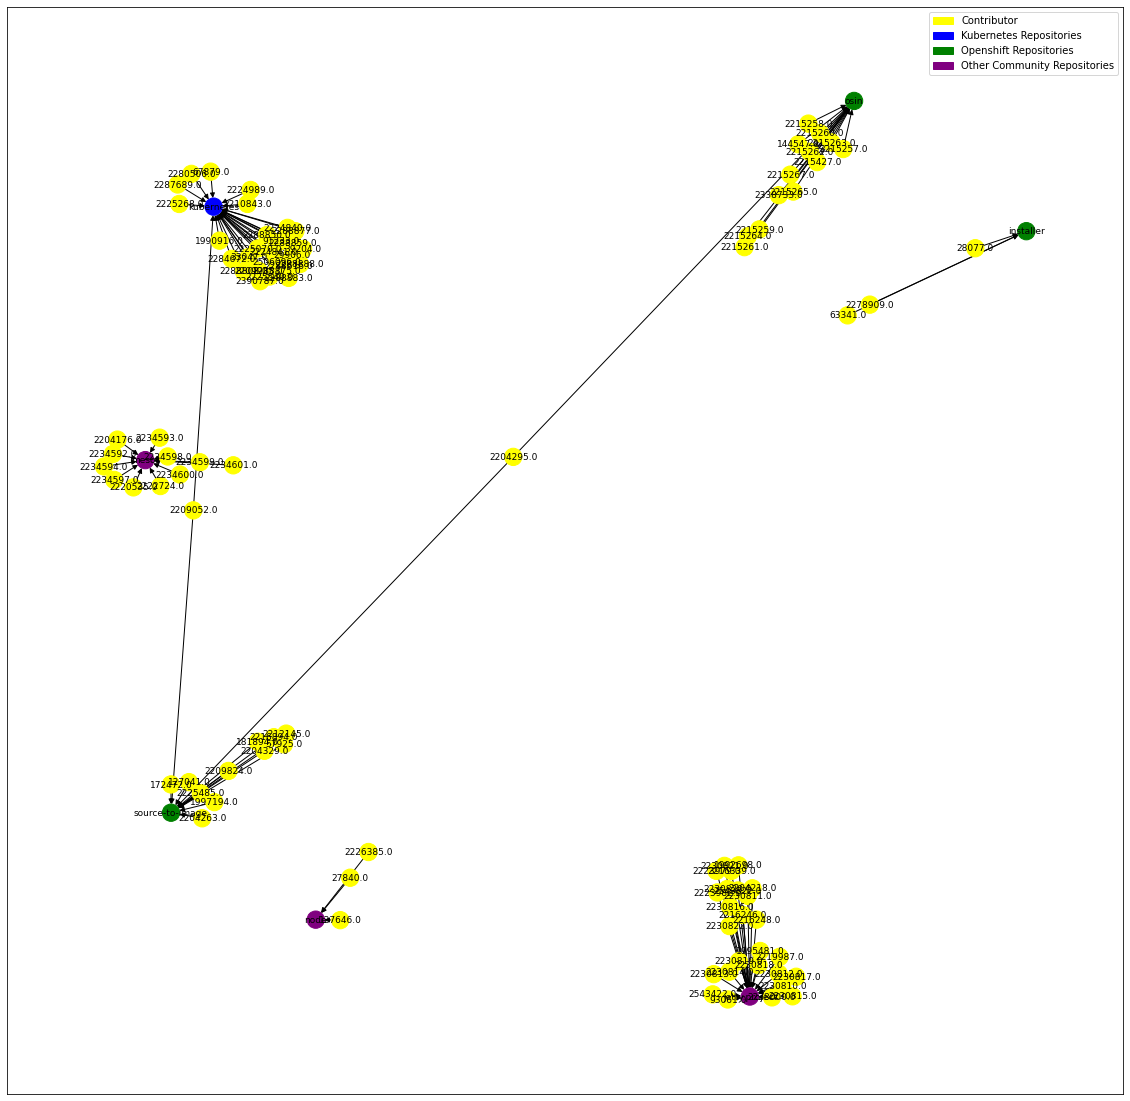

In [35]:
#Creating a directed gra[h to run page rank
H = nx.from_pandas_edgelist(merged_df, 
                            source='cntrb_id',
                            target='repo_name',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

nodes = H.nodes()

Repo_name = merged_df['repo_name'].to_list()
contributor_id = merged_df['cntrb_id'].to_list()

colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    elif n in repo_name_set_other:
        colors.append('purple')
    else:
        colors.append('yellow')
        
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repositories')
green_patch = mpatches.Patch(color='green', label='Openshift Repositories')
purple_patch = mpatches.Patch(color='purple', label='Other Community Repositories')

ax.legend(handles=[yellow_patch, blue_patch, green_patch, purple_patch])
nx.draw_networkx(H, node_color=colors, font_size=9, ax=ax)

In [36]:
pageranks = nx.pagerank(H, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

The first input parameter of the method, H, is the NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge. The second parameter, alpha, is the damping parameter for PageRank and the default value is 0.85. The fourth parameter, max_iter, is the Maximum number of iterations. The seventh parameter, weight, represents the edge attribute that should be used as the edge weight. If it’s not specified, the weight of all edges will be 1.

In [37]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:20])

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

In [38]:
key = topnodes.keys()

In [39]:
subgraph = nx.subgraph(H, key)

In [40]:
subgraph

In [41]:
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    elif n in repo_name_set_other:
        colors.append('purple')
    else:
        colors.append('yellow')

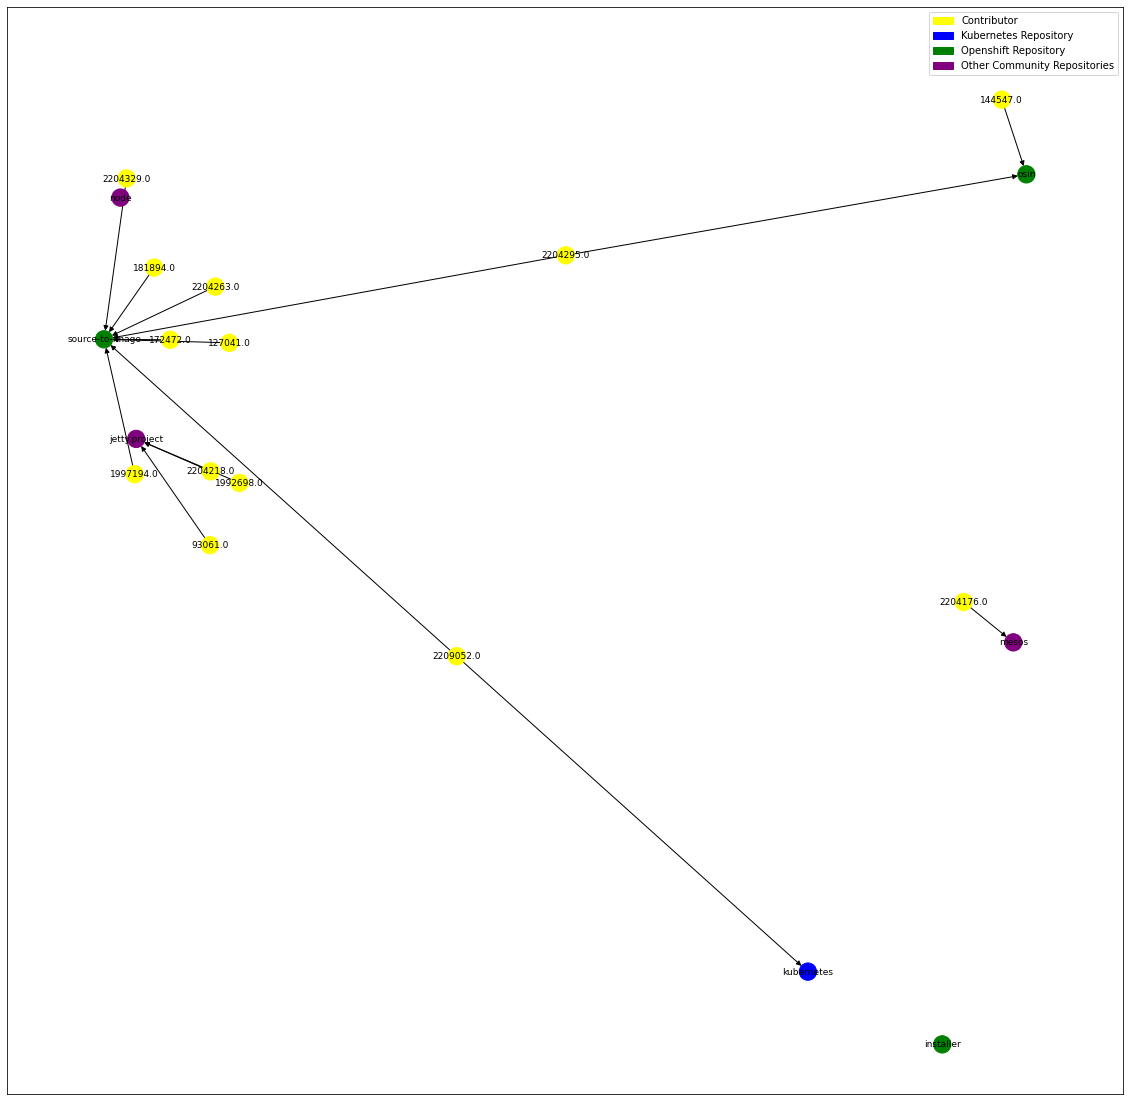

In [42]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
purple_patch = mpatches.Patch(color='purple', label='Other Community Repositories')

ax.legend(handles=[yellow_patch, blue_patch, green_patch, purple_patch])
nx.draw_networkx(subgraph, node_color=colors, font_size=9, ax=ax)

Here we see that some contributor nodes have been eliminated from the graph. However, all the 7 project nodes that we saw previously still remain. The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high. 

In [43]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:3])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    elif n in repo_name_set_other:
        colors.append('purple')
    else:
        colors.append('yellow')

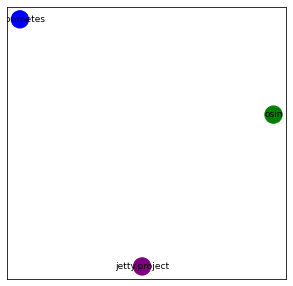

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
nx.draw_networkx(subgraph, node_color=colors, font_size=9, ax=ax)

As we plot the top 3 nodes, we see that a kubernetes repo, an openshift repo as well as an unrelated community repo jetty-project  are shown. **Hence, PageRank may not be the most effective algorithm here to show us important emerging repositories in relation to kubernetes.**

### Betweenness centrality

In [45]:
centrality = nx.betweenness_centrality(G)

In [46]:
sorted( ((v,k) for k,v in centrality.items()), reverse=True)

[(0.21490972626674432, 'kubernetes'),
 (0.1890894971850126, 'source-to-image'),
 (0.1467676179382644, 2209052.0),
 (0.12114152591729761, 'osin'),
 (0.11143467287905261, 2204295.0),
 (0.06309454474859251, 'jetty.project'),
 (0.010677538342069502, 'mesos'),
 (0.0005824111822947001, 'node'),
 (0.0005824111822947001, 'installer'),
 (0.0, 2543822.0),
 (0.0, 2543422.0),
 (0.0, 2506096.0),
 (0.0, 2390787.0),
 (0.0, 2338733.0),
 (0.0, 2288888.0),
 (0.0, 2288883.0),
 (0.0, 2288877.0),
 (0.0, 2288875.0),
 (0.0, 2288859.0),
 (0.0, 2288850.0),
 (0.0, 2288808.0),
 (0.0, 2288616.0),
 (0.0, 2287689.0),
 (0.0, 2284672.0),
 (0.0, 2280506.0),
 (0.0, 2278909.0),
 (0.0, 2234601.0),
 (0.0, 2234600.0),
 (0.0, 2234599.0),
 (0.0, 2234598.0),
 (0.0, 2234597.0),
 (0.0, 2234594.0),
 (0.0, 2234593.0),
 (0.0, 2234592.0),
 (0.0, 2230822.0),
 (0.0, 2230821.0),
 (0.0, 2230820.0),
 (0.0, 2230819.0),
 (0.0, 2230818.0),
 (0.0, 2230817.0),
 (0.0, 2230816.0),
 (0.0, 2230815.0),
 (0.0, 2230814.0),
 (0.0, 2230813.0),
 (0.0,

Using centrality, we get better results. We see that the top most-central repos belong to kubernetes and openshift repositories.

## Graph Type 2: Nodes as projects edges as contributors

In this section, we represent data in another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

In [47]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,jetty.project,93061.0,2.0
1,source-to-image,127041.0,7.0
2,osin,144547.0,1.0
3,source-to-image,172472.0,2.0
4,source-to-image,181894.0,15.0


In [48]:
contributorGraph = {}
for i, row in merged_df.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['total_contributions'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['total_contributions']))

In [49]:
list(contributorGraph.items())[:20]

[(93061.0, [('jetty.project', 2.0)]),
 (127041.0, [('source-to-image', 7.0)]),
 (144547.0, [('osin', 1.0)]),
 (172472.0, [('source-to-image', 2.0)]),
 (181894.0, [('source-to-image', 15.0)]),
 (1992698.0, [('jetty.project', 127.0)]),
 (1997194.0, [('source-to-image', 4.0)]),
 (2204176.0, [('mesos', 10.0)]),
 (2204218.0, [('jetty.project', 19.0)]),
 (2204263.0, [('source-to-image', 4.0)]),
 (2204295.0, [('osin', 15.0), ('source-to-image', 61.0)]),
 (2204329.0, [('source-to-image', 95.0)]),
 (2209052.0, [('source-to-image', 4.0), ('kubernetes', 1.0)]),
 (2209824.0, [('source-to-image', 2.0)]),
 (2212145.0, [('source-to-image', 252.0)]),
 (2215257.0, [('osin', 1.0)]),
 (2215258.0, [('osin', 1.0)]),
 (2215259.0, [('osin', 1.0)]),
 (2215260.0, [('osin', 1.0)]),
 (2215261.0, [('osin', 1.0)])]

`contributorGraph` above is a dictionary where each key is a contributor, and the value is a list of repositories the contributor has contributed to and the number of contributions it has made.


Hence, if there are more than one repositories in the list that corresponds to a single contributor key, they can be thought of as **"connected"** project repositories and we will now calculate the number of **"shared connections"** between them. 

structure of `contributorGraph` =  
{  
`contributor1`: [(`repo1`, `contributions by the contributor1 in repo 1`)],  
 `contributor2`: [(`repo2`, `contributions by the contributor2 in repo 2` ), (`repo1`, `contributions by the contributor2 in repo 1`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [50]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {('osin', 'source-to-image'): 76.0, ('source-to-image', 'kubernetes'): 5.0})


`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [51]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [52]:
g = nx.Graph()
g.add_weighted_edges_from(res)

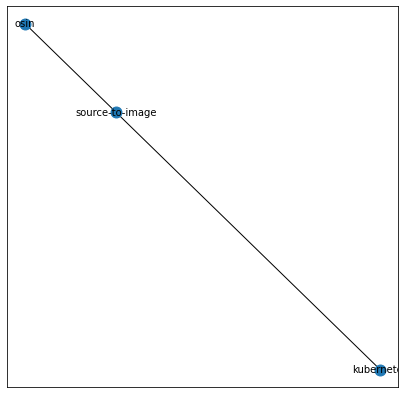

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
nx.draw_networkx(g, node_size=120, font_size=10, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  

We see that this graph representation effectively filters out the repositories we are most interested in seeing. **The repository "closest" to kubernetes are 2 OpenShift repositories "source-to-image" followed by "osin" and the other unrelated community repositories do not appear on the plot as they are not "connected" to kubernetes**

This can be an effective way to filter out interesting repositories in relation to an already prominent community.

## Conclusion



In this notebook, we ran an experiment on known open source GitHub repositories. We looked at a timeframe in history where a new open source community was emerging/becoming popular and we tried to track the rise of the community using graph alrgorithms.

As an example, we wanted to track the emergence of OpenShift as the downstream of Kubernetes. SO we started with some Kubernetes repos, OpenShift repos and some other unrelated repos with the hope that as a result of the analysis, OpenShift will emerge as the community closest in connection to Kubernetes, and the other repos although popular or important in their own context do not emerge.

As a result of creating various types of graphical representations of the Github data and using algorithms like PageRank and Betweenness centrality, we saw that:

1. **PageRank is not effective in showing us important emerging OpenShift repositories in relation to kubernetes.**

2. **Using Betweenness Centrality ranks, we are able to get OpenShift and Kubernetes repos in the top most highly ranked or central repos.**

3. **Using the graph representation type 2 where we represent nodes as projects edges as contributors, we are able to very effectively filter out the repositories we are most interested in seeing ie is Kubernetes and OpenShift repos. We see that the repository "closest" to kubernetes are 2 OpenShift repositories "source-to-image" followed by "osin" and the other unrelated community repositories do not appear on the plot.**